# Feature Detection
we are looking for specific patterns or specific features which are unique, which can be easily tracked, which can be easily compared

In [1]:
import matplotlib, cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Lets try template matching in python opencv

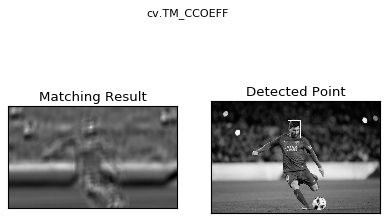

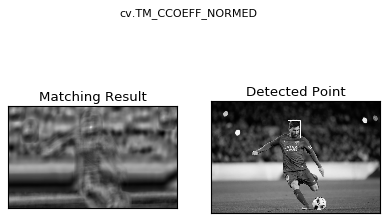

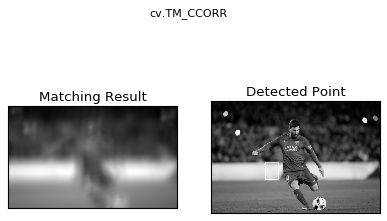

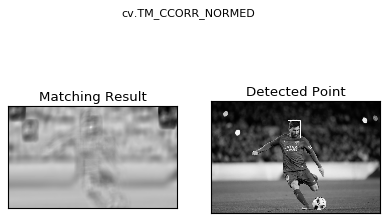

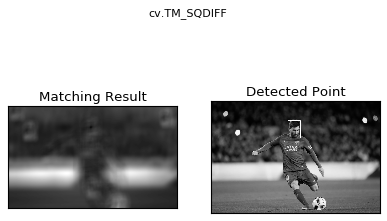

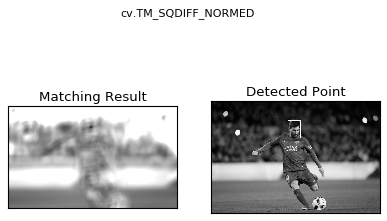

In [3]:
import cv2 as cv
img = cv.imread('../data/image_processing_advanced/messi.jpg',0)
img2 = img.copy()
template = cv.imread('../data/image_processing_advanced/messi_head.png',0)
w, h = template.shape[::-1]
# All the 6 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

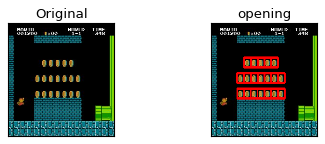

In [4]:
img_rgb = cv.imread('../data/image_processing_advanced/mario.png')
input_img = img_rgb.copy()
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
template = cv.imread('../data/image_processing_advanced/coin.png',0)
w, h = template.shape[::-1]
res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    
plt.subplot(2,2,1),plt.imshow(cv.cvtColor(input_img, cv.COLOR_BGR2RGB))
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(img_rgb,cmap = 'gray')
plt.title('opening'), plt.xticks([]), plt.yticks([])
    
plt.imshow(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB))
plt.show()


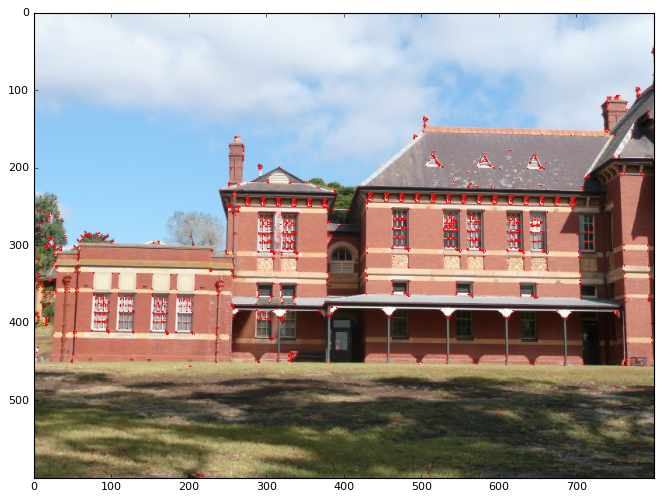

In [5]:
img = cv2.imread('../data/image_processing_advanced/a1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Harris corner detector is not good enough when scale of image changes.


Now let's try to find the interseting 2d features using ORB feature detector

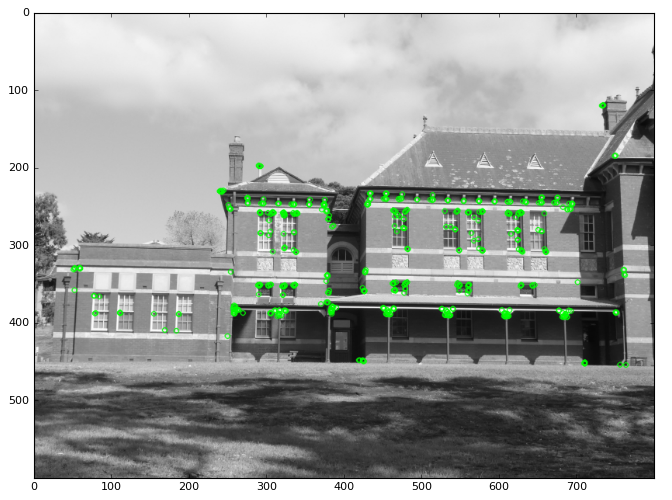

In [6]:
import cv2
img = cv2.imread('../data/image_processing_advanced/a1.jpg',0)

# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(img,None)

# compute the descriptors with ORB
kp, des = orb.compute(img, kp)

# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img,kp,None,color=(0,255,0), flags=0)
plt.figure(figsize=(10,10))
plt.imshow(img2)

# Feature detection and matching
We need to estimate a projective transformation that relates these images together. The steps will be
1. Define one image as a target or destination image, which will remain anchored while the others are warped
2. Detect features in all three images
3. Match features from left and right images against the features in the center, anchored image.

We detect "Oriented FAST and rotated BRIEF" (ORB) features in both images and apply the ratio test to find the best matches.

In [7]:
img1 = cv2.imread('../data/image_processing_advanced/box.png',0)          # queryImage
img2 = cv2.imread('../data/image_processing_advanced/box_in_scene.png',0) # trainImage

MIN_MATCH_COUNT = 10

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

# Match descriptors.
matches = bf.knnMatch(des1,des2,k=2)

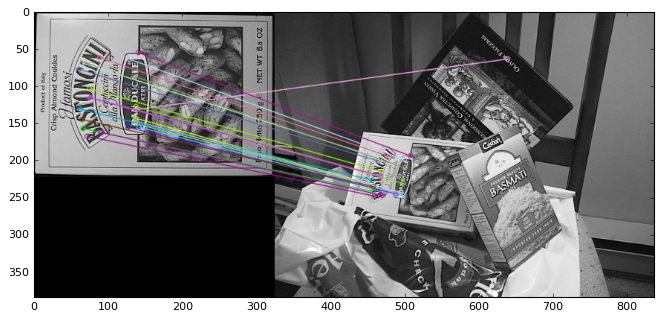

In [8]:
# Find good matches using lowe's ratio
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,flags=2)
plt.figure(figsize=(10,10))
plt.imshow(img3)

Now we set a condition that atleast 10 matches (defined by MIN_MATCH_COUNT) are to be there to find the object. Otherwise simply show a message saying not enough matches are present.

If enough matches are found, we extract the locations of matched keypoints in both the images. They are passed to find the perpective transformation. Once we get this 3x3 transformation matrix, we use it to transform the corners of queryImage to corresponding points in trainImage. Then we draw it.

In [9]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0) #find homography
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

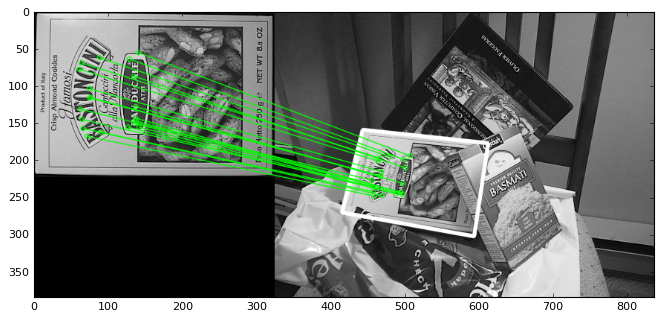

In [10]:
# Finally we draw our inliers (if successfully found the object) or matching keypoints (if failed).
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(10,10))
plt.imshow(img3, 'gray')

In [15]:
print('The end!')

The end!
